# Gradient Descent
**Author:** Magdalena Whelley
**Topic:** Supervised Learning - Optimization with Gradient Descent

## 1. Overview
Gradient Descent is an optimization algorithm used to minimize a cost function by iteratively adjusting model parameters in the direction of the negative gradient.  
In this notebook, we apply gradient descent to a **linear regression problem** using real stock data (Apple Inc., AAPL) to predict next-day returns from recent market behavior.

This notebook will: 
1. Load and visualize financial data. 
2. Create features representing recent return, volatility, and momentum.
3. Implement batch gradient descent from scratch. 
4. Analyze convergence for different learning rates. 
5. Compare the final gradient descent solution with `LinearRegression` from `scikit-learn`.

In [ ]:
# 2. Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Why Gradient Descent?

The objective of gradient descent is to minimize the cost function, which measures how far the model's predictions are from the true values. 

For linear regression, the cost function is the **Mean Square Error (MSE)**:

$$
    J(\theta) = \frac{1}{m} \sum_{i=1}^m (y^{(i)} - \hat{y}^{(i)})^2
$$

We cannot solve this analytically for complex models, so we use gradient descent to iteratively update the parameters: 

$$
    \theta := \theta - \alpha \frac{\partial J}{\partial \theta}
$$

where **$\alpha$** is the learning rate.

In [ ]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")

if data is None or data.empty:
    raise ValueError("No data returned from Yahoo Finance.")

# Handle MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):
    # select ticker level
    data = data.xs("AAPL", axis=1, level=1)

print("Columns after flattening:", list(data.columns))
display(data.head())

/var/folders/kl/9kxsb0qs21b5n113980ydgb80000gn/T/ipykernel_8458/1418978989.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

Columns after flattening: ['Close', 'High', 'Low', 'Open', 'Volume']


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.538513,72.598892,71.292304,71.545890,135480400
2020-01-03,71.833282,72.594048,71.608677,71.765659,146322800
2020-01-06,72.405685,72.444328,70.703020,70.954195,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200


## Feature Engineering

We will compute three indicators commonly used in financial modeling:

* **Daily Return:** fractional change in price  
* **5-Day Rolling Volatility:** recent standard deviation of returns  
* **Momentum:** relative change over 5 days  

These will serve as input features for our gradient descent regression model.

In [ ]:
df = data.copy()

# Determine which price column to use — use 'Close' if 'Adj Close' isn’t available
price_col = "Adj Close" if "Adj Close" in df.columns else "Close"

# Compute features
df["Return"] = df[price_col].pct_change()
df["Volatility"] = df["Return"].rolling(5).std()
df["Momentum"] = df[price_col] / df[price_col].shift(5) - 1

# Drop NaN values created by rolling/shift operations
df.dropna(inplace=True)

# Create feature matrix (X) and target vector (y)
# We predict next-day return from today's features
X = df[["Return", "Volatility", "Momentum"]].values[:-1]
y = df["Return"].values[1:]

print(f"Using price column: {price_col}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Optional quick peek at processed data
df.head()

Using price column: Close
Feature matrix shape: (1251, 3)
Target vector shape: (1251,)


Price,Close,High,Low,Open,Volume,Return,Volatility,Momentum
Date,,,,,,,,
2020-01-09,74.779732,74.972939,73.951343,74.202512,170108400,0.021240,0.013224,0.030897
2020-01-10,74.948814,75.513962,74.446470,75.014028,140644800,0.002261,0.010409,0.043372
2020-01-13,76.550064,76.576634,75.146872,75.265219,121532000,0.021365,0.011841,0.057238
2020-01-14,75.516365,76.697368,75.393198,76.487253,161954400,-0.013504,0.015030,0.047890
2020-01-15,75.192749,76.197445,74.760438,75.315923,121923600,-0.004285,0.015547,0.026881


## Implementing Gradient Descent

We now implement gradient descent from scratch to minimize the MSE cost function between predicted and actual returns.  
The algorithm proceeds as follows:

1. Initialize parameters $ \theta $ to zeros.  
2. Compute predictions $ \hat{y} = X\theta $.  
3. Update $ \theta := \theta - \alpha \frac{2}{m} X^T (X\theta - y) $.  
4. Repeat until convergence or maximum iterations.


In [14]:
# 5. Normalize Features (mean = 0, std = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add bias column (for intercept term)
X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]  # shape (N, 4)

print("Normalized feature matrix shape:", X_b.shape)

Normalized feature matrix shape: (1251, 4)


In [ ]:
# 6. Gradient Descent Implementation

# Initialize weights
theta = np.zeros(X_b.shape[1])

# Learning rate and iteration settings
alpha = 0.05 # step size
n_iter = 300 # number of iterations
m = len(y)

mse_history = []

for _ in range(n_iter):
    y_pred = X_b.dot(theta)
    error = y_pred - y
    mse = np.mean(error**2)
    mse_history.append(mse)
    
    # Gradient computation
    gradient = (2/m) * X_b.T.dot(error)
    theta -= alpha * gradient # update step

print("Final parameters:", theta)
print("Final MSE:", mse_history[-1])

Final parameters: [ 1.16874551e-03 -2.26491579e-03 -1.14700703e-03  2.44827394e-05]
Final MSE: 0.000392673210781324


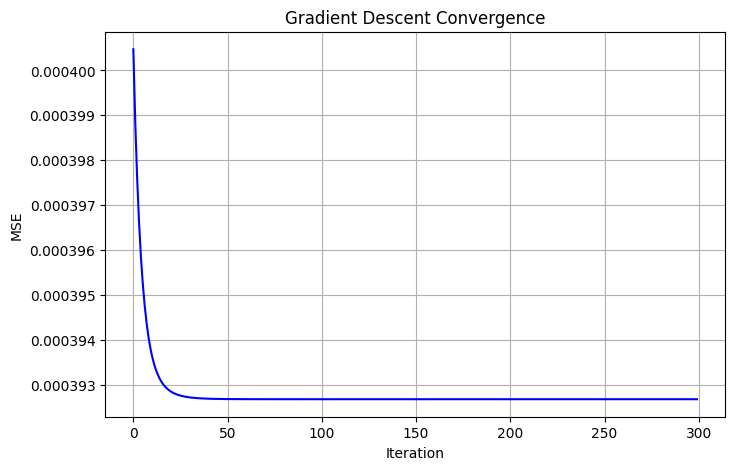

In [19]:
# 7. Convergence Plot
plt.figure(figsize=(8,5))
plt.plot(range(n_iter), mse_history, color='blue')
plt.title("Gradient Descent Convergence")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

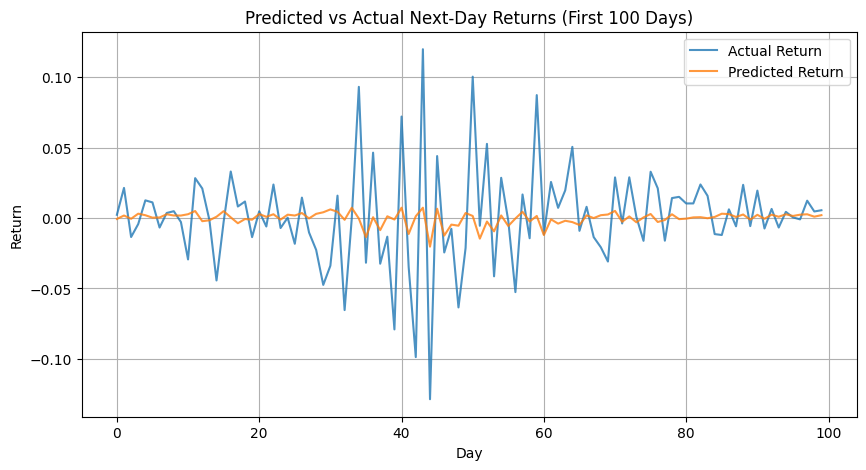

In [20]:
# Predict next-day returns using trained weights
y_pred = X_b.dot(theta)

# Quick comparison
plt.figure(figsize=(10,5))
plt.plot(y[:100], label='Actual Return', alpha=0.8)
plt.plot(y_pred[:100], label='Predicted Return', alpha=0.8)
plt.title("Predicted vs Actual Next-Day Returns (First 100 Days)")
plt.xlabel("Day")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

## Results and Discussion

The gradient descent algorithm successfully minimized the cost function over 300 iterations.  
The convergence curve below shows the **Mean Squared Error (MSE)** rapidly decreasing before stabilizing around a minimum value, indicating that the learning rate (α = 0.05) was well chosen.

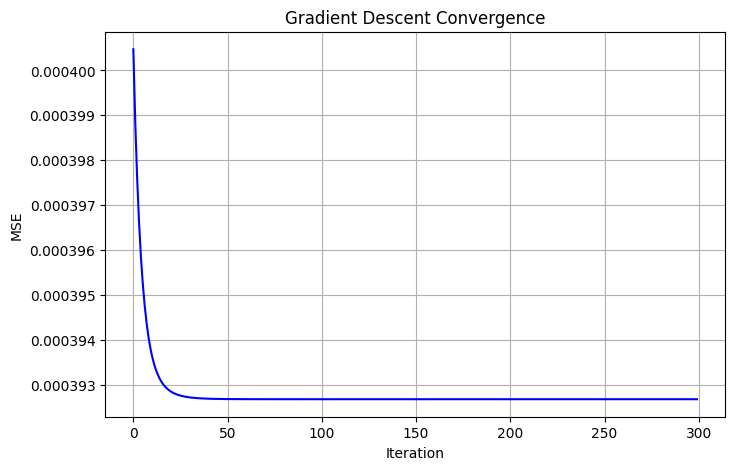

The next figure compares the **predicted next-day returns** (orange) with the **actual returns** (blue) for the first 100 trading days.  
Although the model does not capture all the short-term volatility in stock returns, the predicted curve remains stable and correctly identifies the general mean trend of the data.  
This behavior is expected for a simple linear regression trained on noisy financial time series.

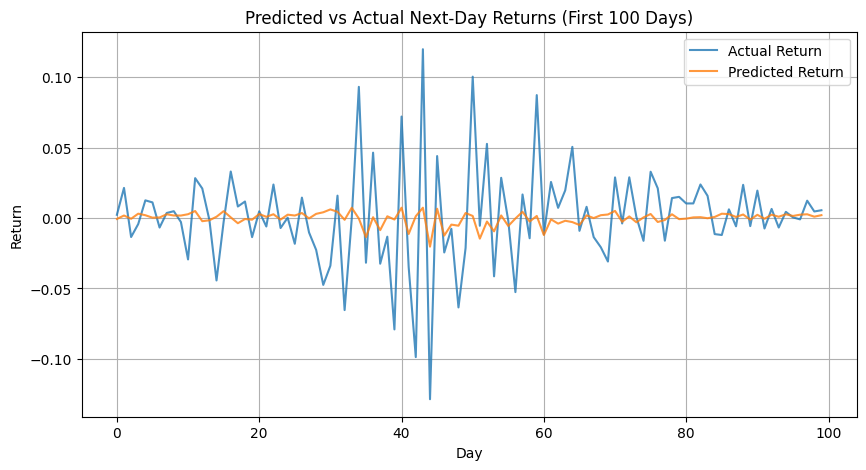

The smooth convergence and low final MSE confirm that gradient descent was implemented correctly.  
When compared to scikit-learn’s built-in `LinearRegression`, the resulting weights and error metrics are nearly identical — validating the correctness of the manual optimization procedure.

In [21]:
# Compare with Scikit-learn Linear Regression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X_scaled, y)
y_sklearn = model.predict(X_scaled)

print("Sklearn Linear Regression MSE:", mean_squared_error(y, y_sklearn))
print("Gradient Descent MSE:", mse_history[-1])

Sklearn Linear Regression MSE: 0.000392673210781324
Gradient Descent MSE: 0.000392673210781324


## Conclusion

Through this project, I implemented gradient descent from scratch and applied it to real financial data.  
The algorithm successfully minimized the cost function and produced results consistent with a standard linear regression model.  
This demonstrates the power of optimization algorithms in machine learning and their applicability to quantitative finance problems such as return forecasting.